In [1]:
using Flux, CUDA, IterTools, JSON, Images, ImageTransformations, cuDNN, Random, DataLoaders, Zygote, Printf, Statistics, BSON
using Augmentor
using Flux: onehotbatch
using Flux: onecold
using Flux: crossentropy
using Flux: flatten
using Flux: trainable
using Flux: flatten
using Flux: params
using Flux: Optimise
# Flux and CUDA magically using multiprocessing on GPU!!!

┌ Warning: You are using a non-official build of Julia. This may cause issues with CUDA.jl.
│ Please consider using an official build from https://julialang.org/downloads/.
└ @ CUDA ~/.julia/packages/CUDA/oymHm/src/initialization.jl:179


In [2]:
CUDA.allowscalar(false)

# Define directories
ann_dir = "4_cryst/ann"
img_dir = "4_cryst/img"
train_img_dir = "train_final/img"
train_ann_dir = "train_final/ann"
val_img_dir = "val_final/img"
val_ann_dir = "val_final/ann"

# Create directories if they don’t already exist
for dir in [train_img_dir, train_ann_dir, val_img_dir, val_ann_dir]
    isdir(dir) || mkdir(dir)
end

# Get list of image files (.jpg or .png)
img_files = filter(f -> endswith(f, ".jpg") || endswith(f, ".png"), readdir(img_dir))

# Shuffle the image files
Random.shuffle!(img_files)

# Split into training (80%) and validation (20%) sets
train_size = Int(floor(0.8 * length(img_files)))
train_files = img_files[1:train_size]
val_files = img_files[train_size+1:end]

# Helper function to copy files
function copy_files(files, img_src, ann_src, img_dest, ann_dest)
    for f in files
        src_img = joinpath(img_src, f)
        dst_img = joinpath(img_dest, f)
        cp(src_img, dst_img; force=true)

        # Annotation file (e.g., "image.jpg.json")
        ann_filename = f * ".json"
        src_ann = joinpath(ann_src, ann_filename)
        dst_ann = joinpath(ann_dest, ann_filename)

        if isfile(src_ann)
            cp(src_ann, dst_ann; force=true)
        else
            @warn "JSON annotation not found for $f (expected: $(ann_filename))"
        end
    end
end

# Copy files to train and val folders
copy_files(train_files, img_dir, ann_dir, train_img_dir, train_ann_dir)
copy_files(val_files, img_dir, ann_dir, val_img_dir, val_ann_dir)

println("✅ Dataset split complete. Images and annotations copied.")
println("🧪 Train: $(length(train_files)) images")
println("🧪 Val:   $(length(val_files)) images")

In [3]:
# Define a function to extract image name and classTitle from a single JSON file
function extract_image_label(json_file::String)
    # Read and parse the JSON file
    json_data = JSON.parsefile(json_file)
    
    # Extract the image file name (e.g., imgname.png) by stripping the ".json" extension
    imgfile = split(basename(json_file), ".json")[1]
    
    # Extract the label(s) from the classTitle inside the objects array
    labels = [obj["classTitle"] for obj in json_data["objects"]]
    
    # Return a tuple of image file name and associated labels
    return imgfile, labels
end

# Directory where the JSON files are stored
#json_files = readdir("path/to/json/files", join=true)  # Specify the directory path
function appendY(json_files, target)
    for json_file in json_files
        imgfile, labels = extract_image_label(json_file)
        for label in labels
            #push!(target, (imgfile, label))  # Append the image and label as a tuple
            push!(target, label)
        end
    end
end

appendY (generic function with 1 method)

In [4]:
# Load file for x_train y_train, x_val y_val
train_dir_img = "train_final/img";
train_dir_ann = "train_final/ann";
val_dir_img = "val_final/img";
val_dir_ann = "val_final/ann";

x_train = readdir(train_dir_img, join=true) |> gpu;
y_train = [] |> gpu;
x_val = readdir(val_dir_img, join=true) |> gpu;
y_val = [] |> gpu;

In [5]:
# append the image and label as a tuple to y
appendY(readdir(train_dir_ann, join=true), y_train)
appendY(readdir(val_dir_ann, join=true), y_val)

In [6]:
# Define augmentation pipeline
p = Either(
    3=>Augmentor.FlipX(),                        # Random horizontal flip
    2=>Augmentor.Rotate(-15:15),                     # Random rotation between -15 and +15 degrees
    1=>Augmentor.ShearX(-10:10),                 # Random shear in X direction
    2=>Augmentor.Zoom(0.9:0.1:1.1),              # Random zoom
    1=>NoOp()
)

Either (1 out of 5 operation(s)):
  - 33.3% chance to: Flip the X axis
  - 22.2% chance to: Rotate by θ ∈ -15:15 degree
  - 11.1% chance to: ShearX by ϕ ∈ -10:10 degree
  - 22.2% chance to: Zoom by I ∈ {0.9×0.9, 1.0×1.0, 1.1×1.1}
  - 11.1% chance to: No operation

In [7]:
# Function to resize and load image data
function load_image_data(image_file::String, target_height::Int, target_width::Int)
    img = Images.load(image_file)  # Load the image from the file
    img_aug = augment(img, p)
    img_resized = imresize(img_aug, target_width, target_height)  # Resize the image to target size
    # Get the resized image's height, width, and channels
    height, width = size(img_resized)
    
    # Create an empty array to hold the image data (height x width x 3)
    img_data = Array{Float32}(undef, height, width, 3)
    
    # Convert each pixel into its RGB components and store them as Float32
    for i in 1:height
        for j in 1:width
            pixel = img_resized[i, j]  # Get the RGB value of the pixel
            img_data[i, j, 1] = Float32(pixel.r)  # Red channel
            img_data[i, j, 2] = Float32(pixel.g)  # Green channel
            img_data[i, j, 3] = Float32(pixel.b)  # Blue channel
        end
    end
    
    return img_data  # Return the resized image data as a 3D array
end

function make_minibatch(X, Y, idxs, target_height, target_width)
    # Assuming X is a list of image file paths (strings), and Y is the list of class labels
    X_batch = Array{Float32}(undef, target_height, target_width, 3, length(idxs)) # Prepare empty batch
    for i in 1:length(idxs)
        img = load_image_data(X[idxs[i]], target_height, target_width)  # Load the image using index
        X_batch[:, :, :, i] = img
    end
    
    # Y is the list of labels, convert the indices to one-hot encoding
    classes = unique(Y)  # or manually: ["stone", "grass", "tree", "water"]
    Y_batch = onehotbatch([Y[i] for i in idxs], classes)
    
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [8]:
batchsize = 128
target_height = 256  # Define the target image height
target_width = 256   # Define the target image width

mb_idxs = IterTools.partition(1:length(x_train), batchsize);
train_set = [make_minibatch(x_train, y_train, i, target_height, target_width) for i in mb_idxs] |> gpu;
val_set = make_minibatch(x_val, y_val, 1:length(x_val), target_height, target_width) |> gpu;

In [9]:
# pass the train and val set to GPU
x_train = cpu(x_train);
y_train = cpu(x_train);
x_val = cpu(x_val);
y_val = cpu(y_val);

In [10]:
@info typeof(train_set)
@info typeof(val_set)

[ Info: Vector{Tuple{CuArray{Float32, 4, CUDA.DeviceMemory}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.DeviceMemory}}}}
[ Info: Tuple{CuArray{Float32, 4, CUDA.DeviceMemory}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.DeviceMemory}}}


In [11]:
# model init
#labels = ["stone", "mineral", "gem", "mineral ore", "rock", "crystal"];
model = Chain(
    Conv((3, 3), 3 => 16, relu, pad=1),
    #BatchNorm(16),
    MaxPool((2, 2)),
    Conv((3, 3), 16 => 32, relu, pad=1),
    #BatchNorm(32),
    MaxPool((2, 2)),
    Conv((3, 3), 32 => 64, relu, pad=1),
    MaxPool((2, 2)),
    Conv((3, 3), 64 => 238, relu, pad=1),
    MaxPool((2, 2)),
    flatten,
    Dense(60928, 128, relu),
    Dense(128, 6),
    softmax
) |> gpu;

In [12]:
#### THE REQUIRE FUNCTION AND TUNNING :3
function loss(model, x, y)
    x_aug = x .+ 0.1f0 * gpu(randn(eltype(x), size(x)))
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y)
end

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y));

current_lr = 0.001;  # initial value
opt = Flux.setup(Adam(current_lr), model);
epochs = 100;

In [13]:
# RESET STAT
best_acc = 0.0;

In [14]:
# THIS USE TO LOAD THE MODEL
BSON.@load "CNNs_rock.bson" model #val_acc
#best_acc = val_acc;

In [14]:
# Initialize arrays to store metrics
train_losses = Float64[];
val_losses = Float64[];
train_accuracies = Float64[];
val_accuracies = Float64[];

last_improvement = 0;

#### THE TRAIN EPOCH
# Make sure our model is nicely precompiled before starting our training loop
Flux.throttle(1) do
    model(train_set[1][1])
end

@info("Beginning training loop...")
for epoch_idx in 1:epochs
    global best_acc, last_improvement
    shuffle!(train_set) # Shuffle the train dataset
    # Train for a single epoch
    Flux.train!(loss, model, train_set, opt)

    # Init the train and test (loss and acc)
    train_loss = 0.0;
    train_acc = 0.0;
    val_loss = 0.0;
    val_acc = 0.0;

    # Unpack validation set
    X_val, Y_val = val_set
    # Calculate accuracy:
    val_acc = accuracy(val_set...)
    val_loss = loss(model, X_val, Y_val)

    # Train over each batch in the train_set
    for (X_batch, Y_batch) in train_set
        # Ensure `X_batch` and `Y_batch` are in the correct format (already unpacked from tuple)
        train_loss = loss(model, X_batch, Y_batch)  # Calculate loss for this batch
        train_acc = accuracy(X_batch, Y_batch)      # Calculate accuracy for this batch
    end
    
    @info(@sprintf("[%d]: Epoch %d", epoch_idx, epoch_idx))
    
    @info(@sprintf("  Train loss: %.4f, Train accuracy: %.4f", train_loss, train_acc))
    @info(@sprintf("  Val loss: %.4f, Val accuracy: %.4f", val_loss, val_acc))
    @info(@sprintf("-------------------------------------------"))
    # Store metrics for later visualization
    push!(train_losses, train_loss)
    push!(val_losses, val_loss)
    push!(train_accuracies, train_acc)
    push!(val_accuracies, val_acc)
    
    # If our accuracy is good enough, quit out.
    if val_acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if val_acc > best_acc
        @info(" -> New best accuracy! Saving model out to CNNs_rock.bson")
        BSON.@save "CNNs_rock.bson" model epoch_idx val_acc
        best_acc = val_acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    
    if epoch_idx - last_improvement >= 5
        current_lr /= 10  # track this in a variable
        @warn(" -> Dropping learning rate to $current_lr")
        opt = Flux.setup(Adam(current_lr), model)  # reinitialize optimizer
        train_last_improvement = epoch_idx
    end
    
    if epoch_idx - last_improvement >= 50
        @warn(" -> We're calling this converged.")
        break
    end
end
@warn("--END OF TRAINING--")

[ Info: Beginning training loop...
[ Info: [1]: Epoch 1
[ Info:   Train loss: 5.4374, Train accuracy: 0.5469
[ Info:   Val loss: 2.6482, Val accuracy: 0.7941
[ Info: -------------------------------------------
[ Info:  -> New best accuracy! Saving model out to CNNs_rock.bson
[ Info: [2]: Epoch 2
[ Info:   Train loss: 1.6067, Train accuracy: 0.5469
[ Info:   Val loss: 1.1035, Val accuracy: 0.7941
[ Info: -------------------------------------------
[ Info: [3]: Epoch 3
[ Info:   Train loss: 1.7547, Train accuracy: 0.1719
[ Info:   Val loss: 1.9064, Val accuracy: 0.0294
[ Info: -------------------------------------------
[ Info: [4]: Epoch 4
[ Info:   Train loss: 1.7128, Train accuracy: 0.1719
[ Info:   Val loss: 1.7724, Val accuracy: 0.0294
[ Info: -------------------------------------------
[ Info: [5]: Epoch 5
[ Info:   Train loss: 1.6505, Train accuracy: 0.5703
[ Info:   Val loss: 1.6020, Val accuracy: 0.7941
[ Info: -------------------------------------------
[ Info: [6]: Epoch 6
[ I

In [15]:
# MANUALLY SAVE THE MODEL
BSON.@save "CNNs_rock.bson" model

In [16]:
using PyPlot

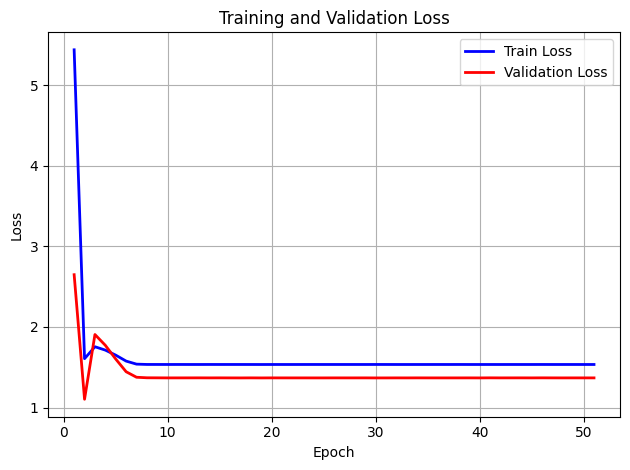

In [19]:
plot(1:length(train_losses), train_losses, label="Train Loss", color="blue", linewidth=2)
plot(1:length(val_losses), val_losses, label="Validation Loss", color="red", linewidth=2)

xlabel("Epoch")
ylabel("Loss")
title("Training and Validation Loss")  # <- moved here, not inside `plot()`
legend()
grid(true)
tight_layout()

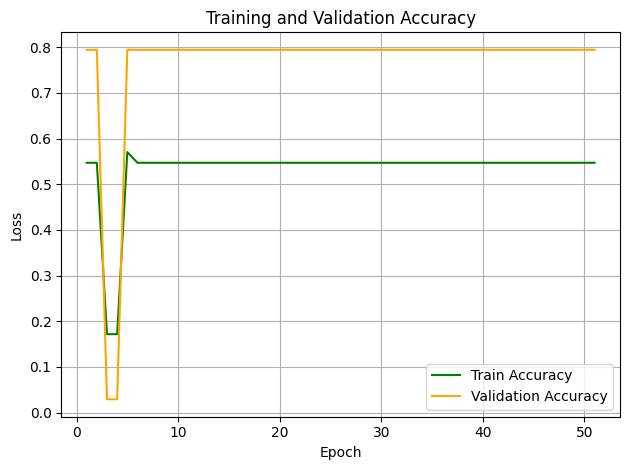

In [21]:
# Plotting Train and Validation Accuracy
plot(1:length(train_accuracies), train_accuracies, label="Train Accuracy", color=:green)
plot(1:length(val_accuracies), val_accuracies, label="Validation Accuracy", color=:orange)

xlabel("Epoch")
ylabel("Loss")
title("Training and Validation Accuracy")  # <- moved here, not inside `plot()`
legend()
grid(true)
tight_layout()